In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import uproot
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from scipy.special import expit  # Sigmoid function




In [30]:
# ============================
# STEP 1: LOAD EVENT DATA
# ============================

# Directory path containing the ROOT files
directory_path = "/eos/purdue/store/user/lingqian/fullrun2_eft_minitrees/spinCorrInput_2016preVFP/Nominal"

# Define the specific files you want to include
desired_files = [
    'ee/ee_ttto2l2nu_jet_smeft_mtt_0to700_2016preVFP.root',
    'ee/ee_ttto2l2nu_jet_smeft_mtt_700to900_2016preVFP.root',
    'ee/ee_ttto2l2nu_jet_smeft_mtt_900toInf_2016preVFP.root',
    'mumu/mumu_ttto2l2nu_jet_smeft_mtt_0to700_2016preVFP.root',
    'mumu/mumu_ttto2l2nu_jet_smeft_mtt_700to900_2016preVFP.root',
    'mumu/mumu_ttto2l2nu_jet_smeft_mtt_900toInf_2016preVFP.root'
]

# Construct the full paths
file_paths = [os.path.join(directory_path, filename) for filename in desired_files]

# Open each ROOT file and extract the TTree
trees = [uproot.open(file_path)['ttBar_treeVariables_step0'] for file_path in file_paths]

# Concatenate all TTrees into a single DataFrame
file = uproot.concatenate(trees)


In [40]:
df = pd.DataFrame({var: file[var] for var in VARS})
df

,gen_ttbar_mass,gen_c_kk,gen_c_rr,gen_c_nn,gen_ll_cHel
0,369.294556,-0.033142,-0.928466,-0.006905,0.968514
1,423.165894,0.095662,-0.221265,-0.531052,0.656654
2,662.066345,-0.042749,-0.258689,-0.645551,0.946988
3,612.362488,0.196327,0.540248,-0.213331,-0.523244
4,412.903900,-0.029048,0.308015,-0.089454,-0.189513
...,...,...,...,...,...
5471297,1088.313110,-0.017014,0.024439,0.095029,-0.102453
5471298,1161.997803,0.598700,0.284702,0.073280,-0.956682
5471299,1308.676147,-0.031032,0.256237,-0.599797,0.374591
5471300,1318.734863,-0.170686,0.384919,0.133034,-0.347267


In [41]:
weight_eft

array([0.11990196, 0.19171169, 0.38946152, ..., 0.00123783, 0.02583181,
       0.00090645])

In [50]:
# ============================
# STEP 2: COMPUTE EVENT WEIGHTS
# ============================
import sys
sys.path.append('/depot/cms/top/bhanda25/EFT_minitree')

from Event_weight_prediction import *
# Define the observables (features)
VARS = ['gen_ttbar_mass', 'gen_c_kk', 'gen_c_rr', 'gen_c_nn', 'gen_ll_cHel']

# Define Wilson coefficient (WC)
WILSON_COEFFS = ['ctGRe']

# Load the structure constant file for EFT weights
SC_saved = np.load('/depot/cms/top/bhanda25/EFT_minitree/Stored_SC/Stored_SC_541k.npy', allow_pickle=True)

# Define the Wilson coefficient range
N = 7  # Number of WC hypotheses
wc_range = np.linspace(-1, 1, N)  # Range of ctGRe values

# SM event weights
weight_sm = file['mgWeights'][:,200]  # SM event weights

# Prepare event datasets
df_list = []
for wc_value in wc_range:
    wc_vector = [0] * 16  # Assume a 16-dimensional Wilson coefficient space
    wc_vector[0] = wc_value  # Modify only the relevant WC

    # Compute EFT event weights
    weight_eft, _, _ = event_weights_lin_quad(SC_saved, wc_vector)

    # Apply the event weights directly to the observables
    df = pd.DataFrame({var: file[var] * weight_eft for var in VARS})  # Scale observables
    df['ctGRe'] = wc_value  # Save WC value
    df['isSignal'] = np.ones(len(df))  # Label as EFT

    df_list.append(df)

# Combine all generated EFT datasets
df_total = pd.concat(df_list)

# Duplicate for SM (without reweighting)
df_sm = pd.DataFrame({var: file[var]*weight_sm for var in VARS})
df_sm['ctGRe'] = 0.0  # SM corresponds to ctGRe=0
df_sm['isSignal'] = np.zeros(len(df_sm))  # Label as SM

# Combine SM and EFT datasets
df_all = pd.concat([df_total, df_sm])

# ============================
# STEP 2: COMPUTE EVENT WEIGHTS
# ============================
import sys
sys.path.append('/depot/cms/top/bhanda25/EFT_minitree')

from Event_weight_prediction import *
import numpy as np
import pandas as pd

# Define the observables (features)
VARS = ['gen_ttbar_mass', 'gen_c_kk', 'gen_c_rr', 'gen_c_nn', 'gen_ll_cHel']

# Define Wilson coefficient (WC)
WILSON_COEFFS = ['ctGRe']

# Load the structure constant file for EFT weights
SC_saved = np.load('/depot/cms/top/bhanda25/EFT_minitree/Stored_SC/Stored_SC_541k.npy', allow_pickle=True)

# Define the Wilson coefficient range
N = 7  # Number of WC hypotheses
wc_range = np.linspace(-1, 1, N)  # Range of ctGRe values

# SM event weights
weight_sm = file['mgWeights'][:, 200]  # SM event weights

# Prepare event datasets
df_list = []
for wc_value in wc_range:
    wc_vector = [0] * 16  # Assume a 16-dimensional Wilson coefficient space
    wc_vector[0] = wc_value  # Modify only the relevant WC

    # Compute EFT event weights
    weight_eft, _, _ = event_weights_lin_quad(SC_saved, wc_vector)

    # Apply the event weights directly to the observables
    df = pd.DataFrame({var: file[var] * weight_eft for var in VARS})  # Scale observables
    df['ctGRe'] = wc_value  # Save WC value
    df['isSignal'] = np.ones(len(df))  # Label as EFT

    df_list.append(df)

# Combine all generated EFT datasets
df_total = pd.concat(df_list)

# Duplicate for SM (without reweighting)
df_sm = pd.DataFrame({var: file[var] * weight_sm for var in VARS})
df_sm['ctGRe'] = 0.0  # SM corresponds to ctGRe=0
df_sm['isSignal'] = np.zeros(len(df_sm))  # Label as SM

# Combine SM and EFT datasets
df_all = pd.concat([df_total, df_sm])



In [79]:
df_list

[         gen_ttbar_mass  gen_c_kk  gen_c_rr  gen_c_nn  gen_ll_cHel  ctGRe  \
 0            429.420887 -0.038539 -1.079634 -0.008029     1.126201   -1.0   
 1            356.416060  0.080572 -0.186362 -0.447284     0.553074   -1.0   
 2            610.701716 -0.039432 -0.238619 -0.595467     0.873518   -1.0   
 3            259.185282  0.083096  0.228662 -0.090293    -0.221465   -1.0   
 4            455.147988 -0.032020  0.339527 -0.098606    -0.208902   -1.0   
 ...                 ...       ...       ...       ...          ...    ...   
 5471297       89.949653 -0.001406  0.002020  0.007854    -0.008468   -1.0   
 5471298        5.782186  0.002979  0.001417  0.000365    -0.004761   -1.0   
 5471299       19.472427 -0.000462  0.003813 -0.008925     0.005574   -1.0   
 5471300       29.063885 -0.003762  0.008483  0.002932    -0.007653   -1.0   
 5471301       16.103835  0.009465 -0.000119 -0.003041    -0.006305   -1.0   
 
          isSignal  
 0             1.0  
 1             1.0  

In [68]:
# ============================
# STEP 3: LIMIT TOTAL EVENTS TO 500,000
# ============================

MAX_EVENTS = 50000  # Limit on total number of events

# Shuffle dataset before sampling
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)

# Ensure we do not exceed 500,000 events
if len(df_all) > MAX_EVENTS:
    df_all = df_all.sample(n=MAX_EVENTS, random_state=42)

In [69]:
df_all

,gen_ttbar_mass,gen_c_kk,gen_c_rr,gen_c_nn,gen_ll_cHel,ctGRe,isSignal
104241,251.961909,-0.398560,0.101106,0.086903,0.210550,0.666667,1.0
199676,1.740917,0.001271,0.000002,-0.000030,-0.001243,-0.666667,1.0
140199,12.847911,-0.000881,0.000068,0.004428,-0.003615,0.000000,0.0
132814,0.786452,0.000000,-0.000000,0.000000,-0.000000,1.000000,1.0
408697,262.698151,0.192750,-0.169125,0.161008,-0.184632,0.000000,0.0
...,...,...,...,...,...,...,...
100088,797.118658,-0.809074,0.050113,-0.111360,0.870320,-1.000000,1.0
156438,370.186328,0.002600,0.513027,-0.051450,-0.464177,0.666667,1.0
306204,855.563412,-0.141999,-0.190579,0.569371,-0.236793,-1.000000,1.0
8817,756.168800,0.000000,-0.000000,0.000000,0.000000,-0.666667,1.0


In [73]:
# ============================
# STEP 3: PREPROCESS DATA
# ============================

# Split into training and test sets
df_train, df_test = train_test_split(df_all, test_size=0.2, random_state=42)

# Extract features (observables + Wilson coefficients) and labels
X_train, y_train = df_train[VARS + WILSON_COEFFS].values, df_train["isSignal"].values
X_test, y_test = df_test[VARS + WILSON_COEFFS].values, df_test["isSignal"].values

# Apply standard scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [74]:
X_train_tensor

tensor([[ 0.3405,  1.2132,  1.4022,  0.4492, -1.7552,  0.0050],
        [-1.0255,  0.0554,  0.0901,  0.0825, -0.1309,  0.0050],
        [ 0.8736, -0.6613,  0.2571,  0.6380, -0.1376,  0.0050],
        ...,
        [-1.1368,  0.0629, -0.0117,  0.0826, -0.0771,  0.0050],
        [-0.2128,  0.7674, -0.3801, -1.2756,  0.5161,  0.5400],
        [-0.1573,  0.0622, -0.4709, -1.2982,  0.9846,  0.5400]])

In [75]:
# ============================
# STEP 4: DEFINE PARAMETERIZED CLASSIFIER
# ============================

class ParamLikelihoodClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize model, loss, and optimizer
input_size = len(VARS) + len(WILSON_COEFFS)
model = ParamLikelihoodClassifier(input_size)
loss_fn =  nn.BCELoss()  # Training in log-likelihood space
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [76]:
# ============================
# STEP 4: TRAIN THE CLASSIFIER
# ============================
from tqdm import tqdm 
batch_size = 1024
epochs = 20

# Prepare data loaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Track loss
train_losses = []

# Training loop
for epoch in tqdm(range(epochs), desc="Epoch Progress", unit="epoch"):
    model.train()
    batch_loss = []

    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        batch_loss.append(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = np.mean(batch_loss)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {avg_loss:.4f}")



Epoch Progress:   5%|▌         | 1/20 [00:05<01:37,  5.14s/epoch]

Epoch 1/20 - Training Loss: 0.5034


Epoch Progress:  10%|█         | 2/20 [00:10<01:32,  5.11s/epoch]

Epoch 2/20 - Training Loss: 0.3515


Epoch Progress:  15%|█▌        | 3/20 [00:15<01:26,  5.12s/epoch]

Epoch 3/20 - Training Loss: 0.2949


Epoch Progress:  20%|██        | 4/20 [00:20<01:22,  5.14s/epoch]

Epoch 4/20 - Training Loss: 0.2251


Epoch Progress:  25%|██▌       | 5/20 [00:25<01:16,  5.13s/epoch]

Epoch 5/20 - Training Loss: 0.1974


Epoch Progress:  30%|███       | 6/20 [00:30<01:12,  5.16s/epoch]

Epoch 6/20 - Training Loss: 0.1859


Epoch Progress:  35%|███▌      | 7/20 [00:35<01:06,  5.13s/epoch]

Epoch 7/20 - Training Loss: 0.1806


Epoch Progress:  40%|████      | 8/20 [00:41<01:01,  5.16s/epoch]

Epoch 8/20 - Training Loss: 0.1796


Epoch Progress:  45%|████▌     | 9/20 [00:46<00:57,  5.20s/epoch]

Epoch 9/20 - Training Loss: 0.1765


Epoch Progress:  50%|█████     | 10/20 [00:51<00:52,  5.20s/epoch]

Epoch 10/20 - Training Loss: 0.1756


Epoch Progress:  55%|█████▌    | 11/20 [00:56<00:45,  5.05s/epoch]

Epoch 11/20 - Training Loss: 0.1763


Epoch Progress:  60%|██████    | 12/20 [00:58<00:33,  4.21s/epoch]

Epoch 12/20 - Training Loss: 0.1752


Epoch Progress:  65%|██████▌   | 13/20 [01:02<00:28,  4.02s/epoch]

Epoch 13/20 - Training Loss: 0.1744


Epoch Progress:  70%|███████   | 14/20 [01:03<00:19,  3.26s/epoch]

Epoch 14/20 - Training Loss: 0.1740


Epoch Progress:  75%|███████▌  | 15/20 [01:04<00:12,  2.52s/epoch]

Epoch 15/20 - Training Loss: 0.1746


Epoch Progress:  80%|████████  | 16/20 [01:06<00:09,  2.27s/epoch]

Epoch 16/20 - Training Loss: 0.1736


Epoch Progress:  85%|████████▌ | 17/20 [01:08<00:07,  2.34s/epoch]

Epoch 17/20 - Training Loss: 0.1729


Epoch Progress:  90%|█████████ | 18/20 [01:09<00:03,  1.94s/epoch]

Epoch 18/20 - Training Loss: 0.1719


Epoch Progress:  95%|█████████▌| 19/20 [01:10<00:01,  1.66s/epoch]

Epoch 19/20 - Training Loss: 0.1724


Epoch Progress: 100%|██████████| 20/20 [01:13<00:00,  3.68s/epoch]

Epoch 20/20 - Training Loss: 0.1721


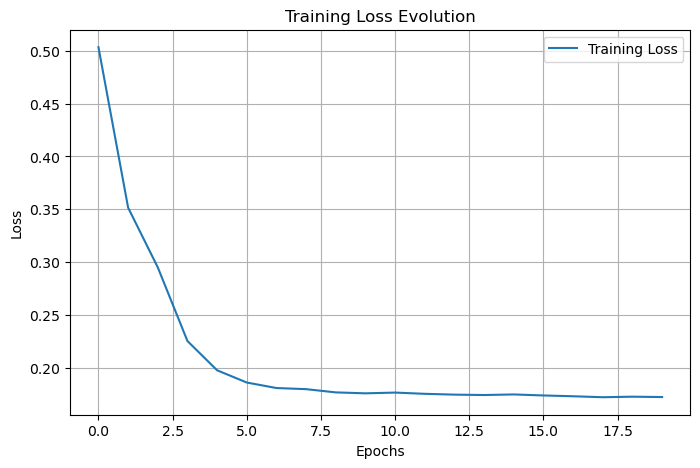

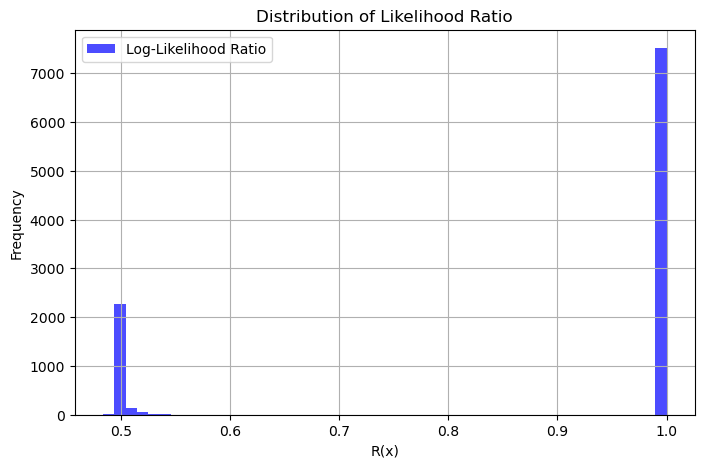

Likelihood Ratio Computation Complete ✅


In [78]:
# ============================
# STEP 5: EVALUATE MODEL
# ============================

model.eval()
with torch.no_grad():
    s_test = model(X_test_tensor).numpy()
    s_train = model(X_train_tensor).numpy()


# ============================
# STEP 6: COMPUTE LIKELIHOOD RATIO
# ============================

def compute_likelihood_ratio(s):
    """Compute likelihood ratio R(x) = (1 - s) / s"""
    return np.divide(1 - s, s, out=np.zeros_like(s), where=s != 0)

# Compute likelihood ratios
likelihood_ratio_test = compute_likelihood_ratio(s_test)
log_likelihood_ratio_test = np.log(likelihood_ratio_test + 1e-10)  # Avoid log(0)

# ============================
# STEP 7: VISUALIZE RESULTS
# ============================

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Evolution")
plt.legend()
plt.grid()
plt.show()

# Plot likelihood ratio distribution
plt.figure(figsize=(8, 5))
plt.hist(s_test, bins=50, alpha=0.7, color="blue", label="Log-Likelihood Ratio")
plt.xlabel("R(x)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Likelihood Ratio")
plt.grid()
plt.show()

print("Likelihood Ratio Computation Complete ✅")

In [63]:
likelihood_ratio_test

array([[0.0000000e+00],
       [1.6689329e-06],
       [5.9604999e-06],
       ...,
       [0.0000000e+00],
       [0.0000000e+00],
       [9.8630452e-01]], dtype=float32)

In [67]:
s_test[:20]

array([[1.        ],
       [0.99999833],
       [0.99999404],
       [0.5034475 ],
       [1.        ],
       [0.5034475 ],
       [0.9999963 ],
       [0.5034475 ],
       [1.        ],
       [0.5034475 ],
       [0.5034475 ],
       [1.        ],
       [0.9999994 ],
       [0.9999962 ],
       [0.99999714],
       [0.9999994 ],
       [1.        ],
       [0.5034475 ],
       [0.9999937 ],
       [0.5034475 ]], dtype=float32)